<a href="https://colab.research.google.com/github/Sahith-Rao/IIIT_internship/blob/main/AL_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  Cloning https://github.com/modAL-python/modAL.git to /tmp/pip-req-build-zvidfqhm
  Running command git clone --filter=blob:none --quiet https://github.com/modAL-python/modAL.git /tmp/pip-req-build-zvidfqhm
  Resolved https://github.com/modAL-python/modAL.git to commit bba6f6fd00dbb862b1e09259b78caf6cffa2e755
  Preparing metadata (setup.py) ... done


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/adhamelkomy/bank-customer-complaint-analysis
License(s): CC0-1.0
bank-customer-complaint-analysis.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  bank-customer-complaint-analysis.zip
replace Bank Customer Complaint Analysis for Efficient Dispute Resolution.ipynb? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Bank Customer Complaint Analysis for Efficient Dispute Resolution.ipynb  
replace complaints.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: complaints.csv          
replace complaints_report_20240226_183305.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: complaints_report_20240226_183305.txt  
replace final_dataframe (1).csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: final_dataframe (1).csv  


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Initial training set: 25985 samples
Pool for active learning: 103943 samples
Test set: 32483 samples

Initial accuracy: 0.8392
Running exactly 20 iterations with 500 samples per query
Iteration 1/20 | Added 500 samples | Total samples: 26485 | Accuracy: 0.8406
Iteration 2/20 | Added 500 samples | Total samples: 26985 | Accuracy: 0.8416
Iteration 3/20 | Added 500 samples | Total samples: 27485 | Accuracy: 0.8414
Iteration 4/20 | Added 500 samples | Total samples: 27985 | Accuracy: 0.8447
Iteration 5/20 | Added 500 samples | Total samples: 28485 | Accuracy: 0.8437
Iteration 6/20 | Added 500 samples | Total samples: 28985 | Accuracy: 0.8449
Iteration 7/20 | Added 500 samples | Total samples: 29485 | Accuracy: 0.8464
Iteration 8/20 | Added 500 samples | Total samples: 29985 | Accuracy: 0.8466
Iteration 9/20 | Added 500 samples | Total samples: 30485 | Accuracy: 0.8471
Iteration 10/20 | Added 500 samples | Total samples: 30985 | Accuracy: 0.8496
Iteration 11/20 | Added 500 samples | Total s

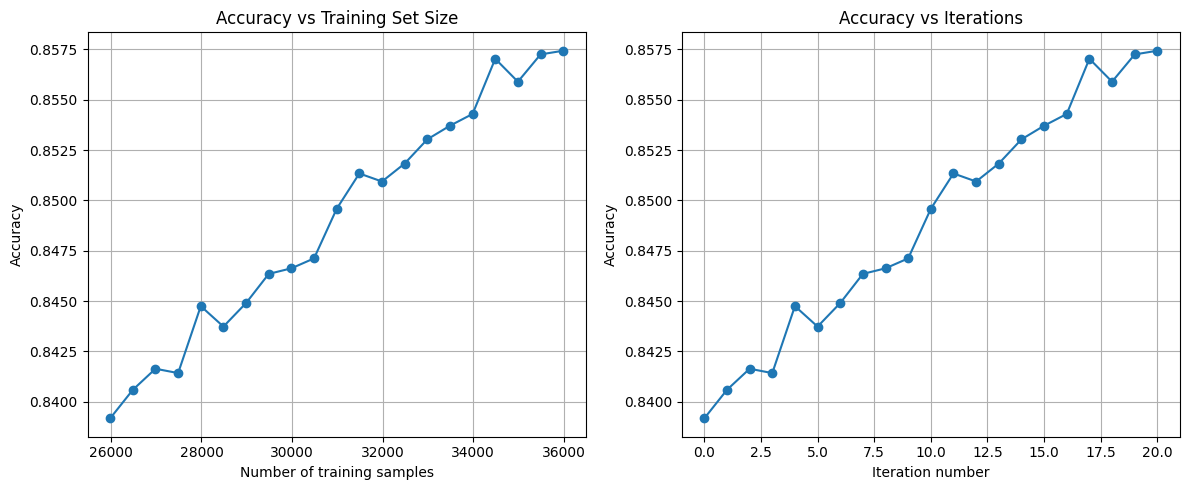


Final Classification Report:
              precision    recall  f1-score   support

           1       0.74      0.77      0.76      3132
           2       0.79      0.90      0.84      2683
           3       0.94      0.88      0.91     18283
           4       0.78      0.85      0.81      3770
           5       0.75      0.79      0.77      4615

    accuracy                           0.86     32483
   macro avg       0.80      0.84      0.82     32483
weighted avg       0.86      0.86      0.86     32483


Top 20 Important Features:
card: 0.0354
debt: 0.0317
loan: 0.0300
credit: 0.0239
mortgage: 0.0223
report: 0.0221
bank: 0.0201
collection: 0.0195
account: 0.0133
payment: 0.0120
money: 0.0119
reporting: 0.0096
transaction: 0.0081
fund: 0.0080
late: 0.0069
bureau: 0.0065
checking: 0.0062
remove: 0.0060
company: 0.0057
experian: 0.0055


In [ ]:
!pip install git+https://github.com/modAL-python/modAL.git
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from google.colab import files
from sklearn.metrics import accuracy_score, classification_report
from modAL.models import ActiveLearner
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

# Upload and load dataset
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d adhamelkomy/bank-customer-complaint-analysis
!unzip bank-customer-complaint-analysis.zip

# Load and preprocess data
df = pd.read_csv("complaints.csv")
df.rename(columns={'Unnamed: 0': 'Complaint_No'}, inplace=True)

# Convert product categories to numerical labels
df["product"] = df["product"].replace({
    "credit_card": "1",
    "retail_banking": "2",
    "credit_reporting": "3",
    "mortgages_and_loans": "4",
    "debt_collection": "5"
}, regex=False)

# Clean data
df = df.dropna()
df["narrative"] = df["narrative"].str.lower()

# Remove punctuation
punc = string.punctuation
def remove_punc(text):
    return text.translate(str.maketrans('', '', punc))
df["narrative"] = df["narrative"].apply(remove_punc)

# Remove stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return " ".join(filtered_words)
df["narrative"] = df["narrative"].apply(lambda x: remove_stopwords(x))

# Prepare features and labels
X = df['narrative'].values
y = df["product"].values

# Split into initial training pool and test set
X_pool, X_test, y_pool, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_pool, y_train, y_pool = train_test_split(X_pool, y_pool, test_size=0.8, random_state=42)

print(f"Initial training set: {len(X_train)} samples")
print(f"Pool for active learning: {len(X_pool)} samples")
print(f"Test set: {len(X_test)} samples")

# Use TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_pool_vec = vectorizer.transform(X_pool)
X_test_vec = vectorizer.transform(X_test)

# Enhanced Random Forest configuration
rf_classifier = RandomForestClassifier(
    n_estimators=200,
    max_depth=30,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Query Strategy (500 samples per query)
def query_strategy_500(classifier, X_pool_vec):
    # Always select 500 samples or remaining pool size if smaller
    batch_size = min(500, X_pool_vec.shape[0])

    # Get prediction probabilities
    probas = classifier.predict_proba(X_pool_vec)

    # Calculate uncertainty (margin between top two predictions)
    if probas.shape[1] >= 2:
        # Get top two probabilities for each sample
        top_probs = -np.partition(-probas, 2, axis=1)[:, :2]
        margins = top_probs[:, 0] - top_probs[:, 1]

        # Get indices of most uncertain samples
        query_idx = np.argpartition(margins, batch_size)[:batch_size]
    else:
        # Fallback to random selection if only one class
        query_idx = np.random.choice(X_pool_vec.shape[0], size=batch_size, replace=False)

    return query_idx, X_pool_vec[query_idx]

# Initialize ActiveLearner
learner = ActiveLearner(
    estimator=rf_classifier,
    query_strategy=query_strategy_500,
    X_training=X_train_vec,
    y_training=y_train
)

# Evaluation function
def evaluate_model(learner, X_vec, y):
    predictions = learner.predict(X_vec)
    return accuracy_score(y, predictions)

# Active learning with exactly 20 iterations
max_queries = 20
performance_history = [evaluate_model(learner, X_test_vec, y_test)]
samples_added_history = [X_train_vec.shape[0]]

print(f"\nInitial accuracy: {performance_history[0]:.4f}")
print(f"Running exactly {max_queries} iterations with 500 samples per query")

for query_num in range(1, max_queries + 1):
    if X_pool_vec.shape[0] == 0:
        print("\nPool exhausted - no more samples available")
        break

    # Query for 500 most uncertain instances
    query_idx, _ = learner.query(X_pool_vec)
    actual_batch_size = len(query_idx)

    # Teach with new samples
    learner.teach(X=X_pool_vec[query_idx], y=y_pool[query_idx])

    # Remove from pool
    mask = np.ones(X_pool_vec.shape[0], dtype=bool)
    mask[query_idx] = False
    X_pool_vec = X_pool_vec[mask]
    y_pool = y_pool[mask]

    # Evaluate
    current_acc = evaluate_model(learner, X_test_vec, y_test)
    performance_history.append(current_acc)
    samples_added_history.append(samples_added_history[-1] + actual_batch_size)

    print(f"Iteration {query_num}/{max_queries} | "
          f"Added {actual_batch_size} samples | "
          f"Total samples: {samples_added_history[-1]} | "
          f"Accuracy: {current_acc:.4f}")

# Plot learning curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(samples_added_history, performance_history, marker='o')
plt.title('Accuracy vs Training Set Size')
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(len(performance_history)), performance_history, marker='o')
plt.title('Accuracy vs Iterations')
plt.xlabel('Iteration number')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

# Final evaluation
final_predictions = learner.predict(X_test_vec)
print("\nFinal Classification Report:")
print(classification_report(y_test, final_predictions))

# Feature importance analysis
if hasattr(learner.estimator, 'feature_importances_'):
    feature_importances = learner.estimator.feature_importances_
    vocab = vectorizer.get_feature_names_out()
    sorted_features = sorted(zip(vocab, feature_importances), key=lambda x: x[1], reverse=True)
    print("\nTop 20 Important Features:")
    for feature, importance in sorted_features[:20]:
        print(f"{feature}: {importance:.4f}")